# SD-TSIA204_lab2 : linear regression
##### Romain Darous
*Run the code once to update the outputs. Expected total runtime : 3 min max.*

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as rd

from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.utils import resample

from scipy.stats import norm, t
import seaborn as sns


## Preprocess the data
### Question 1

In [2]:
# 1.a - setting the random seed to 0
np.random.seed(0)
rd.seed(0)

# 1.b - loading the data
df = pd.read_csv('meatspec.csv')

print("Mean of some covariates \n\n ", df.mean()[:-1].head(), "\n")
print("Standard deviation of some covariates \n\n", df.std()[:-1].head())


Mean of some covariates 

  V1    2.808561
V2    2.811137
V3    2.813727
V4    2.816363
V5    2.819098
dtype: float64 

Standard deviation of some covariates 

 V1    0.410793
V2    0.413352
V3    0.415906
V4    0.418465
V5    0.421040
dtype: float64


- The data **is not centered** as the mean of some covariates is not zero.
- The data **is not standardized** as the mean of some covariates is not zero and their standard deviation is not one.
- The data **is not normalized** as the mean of some covariates is strictly greater than 1. It means they take values which are not in $[0, 1]$

In [3]:
# 1.c - separating data in a train set and a test set
df_train, df_test = train_test_split(df, test_size=0.25, random_state=0)

# 1.c - standardizing the data
scaler = StandardScaler()
df_train = pd.DataFrame(scaler.fit_transform(df_train), columns=df.columns)
df_test = pd.DataFrame(scaler.transform(df_test), columns=df.columns)

# checking standardization
print("Mean of some df_train covariates : \n",
      df_train.mean().round(2).iloc[-3:], '\n')
print("Standard deviation of some df_train covariates : \n",
      df_train.std().round(2).iloc[-3:], '\n')
print("Mean of some df_train covariates : \n",
      df_test.mean().round(2).iloc[-3:], '\n')
print("Standard deviation of some df_train covariates : \n",
      df_test.std().round(2).iloc[-3:], '\n')

# splitting dataframes
X_train = df_train.iloc[:, :-1]
X_test = df_test.iloc[:, :-1]

Y_train = df_train.iloc[:, -1:]
Y_test = df_test.iloc[:, -1:]

Mean of some df_train covariates : 
 V99     0.0
V100   -0.0
fat     0.0
dtype: float64 

Standard deviation of some df_train covariates : 
 V99     1.0
V100    1.0
fat     1.0
dtype: float64 

Mean of some df_train covariates : 
 V99     0.13
V100    0.13
fat     0.01
dtype: float64 

Standard deviation of some df_train covariates : 
 V99     0.89
V100    0.89
fat     1.01
dtype: float64 



It is normal if the standardization does not give exactly a zero mean and a one standard deviation for features of the test set, as it based on the parameters of the train set, to avoid bias.

#### Question 1.d
As we use centered data due to standardization, we can **do OLS without the intercept**. According to the course, this regression is equivalent to doing OLS with intercept and not centered data.

In [4]:
# 1.d - fitting a regular OLS
reg = LinearRegression(fit_intercept=False)
reg.fit(X_train, Y_train)

# printing MSE
ols_mse = mean_squared_error(reg.predict(X_test), Y_test)
print(f"MSE of the regular OLS for the test set : ", ols_mse)


# 1.e - storing R2 coefficients of the estimated model
df_coef = pd.DataFrame(data=[['Regular OLS', reg.score(X_train, Y_train), reg.score(
    X_test, Y_test), X_train.shape[1]]], columns=['OLS-type', 'R2-train', 'R2-test', 'Feature number'])
df_coef

MSE of the regular OLS for the test set :  0.0401114575802184


,OLS-type,R2-train,R2-test,Feature number
0,Regular OLS,0.995789,0.960055,100


The $R_2$-coefficients are satisfying ($>0.9$), especially the one of the test set, which shows that the model explains the main part of the observed variance.

## Variable selection
### Question 2 - Forward Variable Selection

The chosen model for this part is the **random design model**

Here, we keep the notations of the course (section 3.3).

Our data set is standardized. In this case, $\forall k \in \{1, ... , p\}, \^s_n(\~X_k) = 1$.
<br>
Indeed, $\hat{s}_n\left(\tilde{X}_k\right)^2=e_1^T \hat{G}_n\left(\tilde{X}_k\right)^{-1} e_1$.
<br>
Moreover, we have $\hat{G}_n\left(\tilde{X}_k\right) = $
$
\begin{pmatrix}
\frac{e_1^Te_1}{n} & \frac{e_1^T\tilde{X}_k}{n} \\ \\
\frac{\tilde{X}_k^Te_1}{n} & \frac{\tilde{X}_k^T\tilde{X}_k}{n}
\end{pmatrix} = 
\begin{pmatrix}
1 & \frac{\sum_{i=1}^{n}\tilde{x}_{k,i}}{n} \\ \\
\frac{\sum_{i=1}^{n}\tilde{x}_{k,i}}{n} & 1
\end{pmatrix}$.

as data is standardized gives $\forall k \in \{1, ... , p\}, \tilde{X}_k^T\tilde{X}_k = n$ and every covariate has a zero mean. So we have :

$\hat{G}_n\left(\tilde{X}_k\right)^{-1} = 
\begin{pmatrix}
1 & -\frac{\sum_{i=1}^{n}\tilde{x}_{k,i}}{n} \\ \\
-\frac{\sum_{i=1}^{n}\tilde{x}_{k,i}}{n} & 1
\end{pmatrix}$.

Finally, we have : $\forall k \in \{1, ... , p\}, \hat{s}_n\left(\tilde{X}_k\right)^2=e_1^T \hat{G}_n\left(\tilde{X}_k\right)^{-1} e_1 = 1$.

We check it by some calculus below. In the next steps of the TP, we will take $\forall k \in \{1, ... , p\}, \hat{s}_{n,k} = 1$.



One defines the functions to make useful computations for the forward variable algorithm. The same notation as above are used.

In [5]:
# coefficient of the OLS using only one covariate
def theta_n(r, covariate):  # the first value of r is Y_train
    X_train_one_D = X_train[[covariate]]
    reg = LinearRegression(fit_intercept=False).fit(X_train_one_D, r)

    # getting the coefficient of the regression (the intercept is not returned as it is equal to 0)
    return reg.coef_[0, 0]


def sigma_n(r, covariate):
    n = X_train.shape[0]
    X_train_one_D = np.array([X_train[covariate]]).T
    return np.linalg.norm(r - X_train_one_D * theta_n(r, covariate))**2/(n-2)


def G_n(covariate):
    n = X_train.shape[0]
    one_matrix = np.array([np.ones(n)])
    X_train_one_D = np.array([X_train[covariate]])
    covariate_matrix = np.concatenate((one_matrix, X_train_one_D)).T
    return (covariate_matrix.T @ covariate_matrix)/n


def s_n(covariate):
    inv_G_n = np.linalg.inv(G_n(covariate))
    e_1 = np.array([np.zeros(inv_G_n.shape[0])]).T
    e_1[1, 0] = 1
    return np.sqrt(e_1.T @ inv_G_n @ e_1)[0, 0]


# checking that s_n is equal to 1
print("Example of s_n values for some covariates : \n")
for column in X_train.columns[0:10]:
    print(f"s_n({column}) = {s_n(column).round(2)}")

# returns the covariate's name and the value of the statistic associated to the covariate


def statistical_test(r, covariate):
    n = X_train.shape[0]
    return np.array([covariate, n**(1/2) * np.abs(theta_n(r, covariate)) / (sigma_n(r, covariate) * 1)])

Example of s_n values for some covariates : 

s_n(V1) = 1.0
s_n(V2) = 1.0
s_n(V3) = 1.0
s_n(V4) = 1.0
s_n(V5) = 1.0
s_n(V6) = 1.0
s_n(V7) = 1.0
s_n(V8) = 1.0
s_n(V9) = 1.0
s_n(V10) = 1.0


Implementing the method of the Forward Variable Selection. There is no stopping criteria. Each feature name is linked to its p-value in a dictionary. It is stored by increasing value of the p-value.

In [6]:
# implementing the Forward Variable Selection algorithm
def forward_variable_selection():
    A = set(X_train.columns)
    S = set([])

    df_p_value = pd.DataFrame(columns=['covariate', 'p-value'])
    r = Y_train

    while len(S) != len(A):
        statistical_test_array = np.array(
            [statistical_test(r, covariate) for covariate in (A - S)])
        statistical_test_values = statistical_test_array[:, 1].astype(float)

        # looking for the highest value among statistical tests after linear regression of covariates of the set A - S
        argmax = np.argmax(statistical_test_values)
        covariate = statistical_test_array[argmax, 0]

        # updating r
        X_train_one_D = np.array([X_train[covariate]]).T
        r = r - X_train_one_D * theta_n(r, covariate)

        # adding the covariate to the set S and updating covariate_p_value
        temp_df = pd.DataFrame({
            'covariate': [covariate],
            'p-value': [2*(1 - norm.cdf(statistical_test_values[argmax]))]
        })

        df_p_value = pd.concat([df_p_value, temp_df])
        S.add(covariate)

    return df_p_value.reset_index().drop(['index'], axis=1)


df_p_value = forward_variable_selection()
print(f"Covariate sorted by ascending p-value : \n\n {df_p_value}")

Covariate sorted by ascending p-value : 

    covariate   p-value
0        V41  0.000000
1         V8  0.017611
2        V40  0.017450
3         V7  0.016550
4        V42  0.017183
..       ...       ...
95       V75  0.928604
96       V77  0.945613
97       V76  0.971282
98       V50  0.977822
99       V24  0.977822

[100 rows x 2 columns]


### Question 3 - running OLS with a p-value threshold

In [7]:
# max p-value allowed to use a covariate
p_max = 0.05

# 3.a - applying OLS of the sklearn library
p_max_filter = df_p_value['p-value'] <= p_max
df_p_value = df_p_value[p_max_filter]

selected_X_train = X_train[df_p_value['covariate'].tolist()]
selected_X_test = X_test[df_p_value['covariate'].tolist()]

selected_reg = LinearRegression(
    fit_intercept=False).fit(selected_X_train, Y_train)

# printing selected features
print('Selected features for the OLS : \n\n',
      selected_X_train.columns.tolist(), '\n')

# printing MSE
ols_fvs_mse = mean_squared_error(selected_reg.predict(selected_X_test), Y_test)
print(f"MSE of the Forward Variable Selection OLS for the test set : ", ols_fvs_mse)

Selected features for the OLS : 

 ['V41', 'V8', 'V40', 'V7', 'V42', 'V9', 'V39', 'V6', 'V43', 'V10', 'V38', 'V5', 'V37', 'V11', 'V98', 'V4', 'V44', 'V12', 'V36', 'V3', 'V97', 'V13', 'V99'] 

MSE of the Forward Variable Selection OLS for the test set :  0.04500672842583696


In [8]:
# 3.b - storing the R2_coef in df_coef
temp = pd.DataFrame({
    'OLS-type': ['Forward Variable Selection'],
    'R2-train': [selected_reg.score(selected_X_train, Y_train)],
    'R2-test': [selected_reg.score(selected_X_test, Y_test)],
    'Feature number': [selected_X_train.shape[1]]
})

df_coef = pd.concat([df_coef, temp]).drop_duplicates(
    subset=['OLS-type'], keep='last').reset_index().drop(['index'], axis=1)
df_coef

,OLS-type,R2-train,R2-test,Feature number
0,Regular OLS,0.995789,0.960055,100
1,Forward Variable Selection,0.969415,0.955180,23


There is a slight decrease of $R_2$ coefficients in comparison with the regular OLS (less than $1$% for the test set, so it is negligible). However, there are four times less features, which makes it very efficient. One may notice that to obtain these features, we need first to compute several linear regressions, which increases the computing time.

### Question 4 - Sequential Feature Selector

In [9]:
# applying the forward variable selection of the sklearn module
sfs = SequentialFeatureSelector(LinearRegression(
    fit_intercept=False), direction='forward', n_features_to_select=selected_X_train.shape[1])
sfs.fit(X_train, Y_train)
features_out = sfs.get_feature_names_out(X_train.columns)

In [10]:
# applying OLS of the sklearn library
sfs_X_train = X_train[features_out.tolist()]
sfs_X_test = X_test[features_out.tolist()]

sfs_reg = LinearRegression(fit_intercept=False).fit(sfs_X_train, Y_train)

In [11]:
# storing the R2_coef in df_coef
temp = pd.DataFrame({
    'OLS-type': ['Sequential Feature Selector'],
    'R2-train': [sfs_reg.score(sfs_X_train, Y_train)],
    'R2-test': [sfs_reg.score(sfs_X_test, Y_test)],
    'Feature number': [sfs_X_train.shape[1]]
})

# printing MSE
ols_sfs_mse = mean_squared_error(sfs_reg.predict(sfs_X_test), Y_test)
print(f"MSE of the Sequential Feature Selector OLS for the test set : ", ols_sfs_mse)

df_coef = pd.concat([df_coef, temp]).drop_duplicates(
    subset=['OLS-type'], keep='last').reset_index().drop(['index'], axis=1)
df_coef

MSE of the Sequential Feature Selector OLS for the test set :  0.06152504391008016


,OLS-type,R2-train,R2-test,Feature number
0,Regular OLS,0.995789,0.960055,100
1,Forward Variable Selection,0.969415,0.955180,23
2,Sequential Feature Selector,0.986747,0.938730,23


In [12]:
selected_features = set(selected_X_train.columns)
sfs_features = set(sfs_X_train.columns)


print(
    f"Number of features in common between Forward Variable Selection and Sequential Feature Selector : \n\n {len(selected_features.intersection(sfs_features))}")

Number of features in common between Forward Variable Selection and Sequential Feature Selector : 

 6


#### Question 4.a - Why only 6 features in common ?

Sequential Feature Selector and the Forward Variable Selection algorithm have only six features in common. This can be explained by the fact that the Forward Variable Selection algorithm is based on finding the **smallest p-value** at each iteration among the p-values of the remaining covariates.
<br> <br>
As for the Sequential Feature Selector, it is based on the **cross-validation score** of an estimator. This may explain the difference in the covariates chosen between the two algorithms.

In [13]:
df_coef

,OLS-type,R2-train,R2-test,Feature number
0,Regular OLS,0.995789,0.960055,100
1,Forward Variable Selection,0.969415,0.955180,23
2,Sequential Feature Selector,0.986747,0.938730,23


One may notice that the R2 scores of the Sequential Feature Selector are better than the ones of the Forward Variable Selection algorithm. Selecting features using **cross-validation score** seems to guarantee a **better generalization** of the model. Both still remain satisfying ($> 0.9$). <br>

MSE between models will be compared in question 10.

## Ridge
### Question 5 - coding the ridge estimator

First, we make the datasets scale invariant to calculate the ridge estimator. Scale invariant data sets are ``si_X_train`` and  ``si_X_test``. They will also be used for the Lasso and the Elastic Net estimators.<br/>

**Note** : to make the train and test sets scale invariant, one uses the same normalization matrix for train and test sets to avoid bias in the prediction of Y_test.



In [14]:
# making X_train and X_test scale invariant for the ridge estimator. Specific case where the data set is standardized
def D(X):
    p = X_train.shape[1]

    D = np.eye(p)
    for k in range(p):
        e_k = np.zeros((p, 1))
        e_k[k, 0] = 1
        D[k, k] = np.linalg.norm(X @ e_k)**2
    return D


# scale invariant datasets
si_X_train = X_train @ np.linalg.inv(np.sqrt(D(X_train)))
si_X_test = X_test  @ np.linalg.inv(np.sqrt(D(X_train)))

# implementing the ridge estimator ; it returns the calculated coefficients


def theta_n_ridge(X, Y, alpha):
    (n, p) = X.shape
    return np.array(np.linalg.inv(X.T @ X + n * alpha * np.eye(p)) @ X.T @ Y)


# function that calculates the R_2 coefficient of an estimator, given datasets
def R2_coeff(X, Y, estimator):
    n = X.shape[0]
    one_n = np.ones((n, 1))
    y_mean = Y["fat"].mean()

    return 1 - np.linalg.norm((X.to_numpy() @ estimator) - Y.to_numpy())**2 / np.linalg.norm(Y.to_numpy() - y_mean * one_n)**2

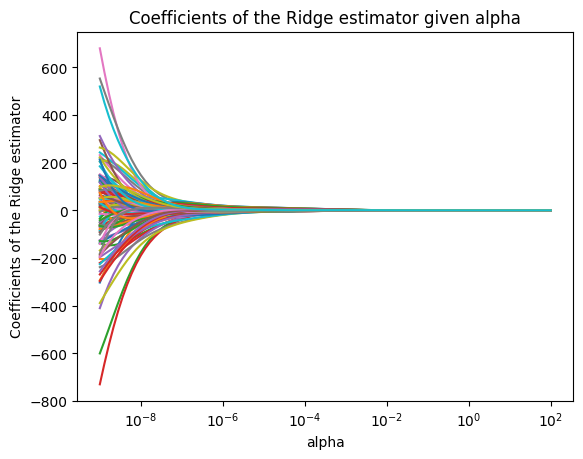

In [15]:
# 5.a - plotting the evolution of the coefficients of the estimator with alpha
ridge_alphas = np.logspace(-9, 2, num=100)
theta_n_ridge_alpha = np.array(
    [theta_n_ridge(si_X_train, Y_train, alpha)[:, 0] for alpha in ridge_alphas])

plt.figure()
plt.rcdefaults()

plt.title("Coefficients of the Ridge estimator given alpha")
plt.ylabel("Coefficients of the Ridge estimator")
plt.xlabel("alpha")

ax = plt.gca()
ax.set_xscale('log')
for i in range(len(ridge_alphas)):
    ax.plot(ridge_alphas, theta_n_ridge_alpha[:, i])

plt.show()

As the ridge estimator formula tells, all the coefficient tend to 0 as alpha goes to infinity. It is a consequence of the fact that the right term of the minimizing problem $\|Y-X \theta\|_2^2+n \alpha\|\boldsymbol{\theta}\|_2^2$ associated to the ridge estimator, becomes preponderant. Minimizing this problem requires $\theta = 0$ starting from $\alpha$ great enough.

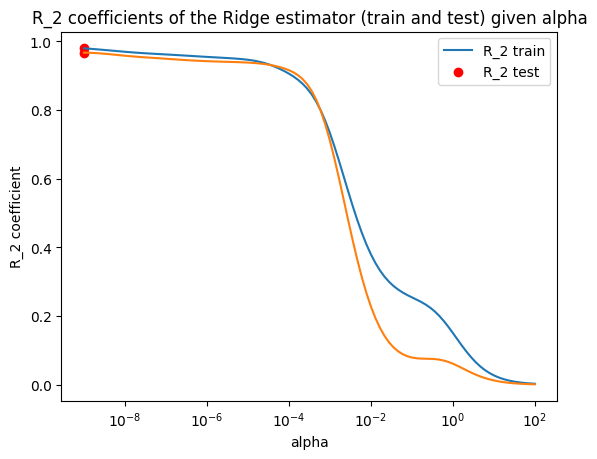

In [16]:
# 5.b - plotting how the values of the R2 cefficients change with alpha
ridge_R2_coeffs_train = np.array([R2_coeff(si_X_train, Y_train, theta_n_ridge(
    si_X_train, Y_train, alpha)) for alpha in ridge_alphas])
ridge_R2_coeffs_test = np.array([R2_coeff(si_X_test, Y_test, theta_n_ridge(
    si_X_train, Y_train, alpha)) for alpha in ridge_alphas])

plt.figure()
plt.rcdefaults()


ax = plt.gca()
ax.set_xscale('log')

# getting indexes which maximize R2 coefficients
ridge_argmax_train = ridge_R2_coeffs_train.argmax()
ridge_argmax_test = ridge_R2_coeffs_test.argmax()

ax.plot(ridge_alphas, ridge_R2_coeffs_train)
ax.scatter(ridge_alphas[ridge_argmax_train],
           ridge_R2_coeffs_train[ridge_argmax_train], color='red')

ax.plot(ridge_alphas, ridge_R2_coeffs_test)
ax.scatter(ridge_alphas[ridge_argmax_test],
           ridge_R2_coeffs_test[ridge_argmax_test], color='red')

plt.xlabel('alpha')
plt.ylabel('R_2 coefficient')
plt.title('R_2 coefficients of the Ridge estimator (train and test) given alpha')

plt.legend(['R_2 train', 'R_2 test'])

plt.show()

One can notice that the $R_2$ coefficient of the train set is greater than the test set one, which is logical.

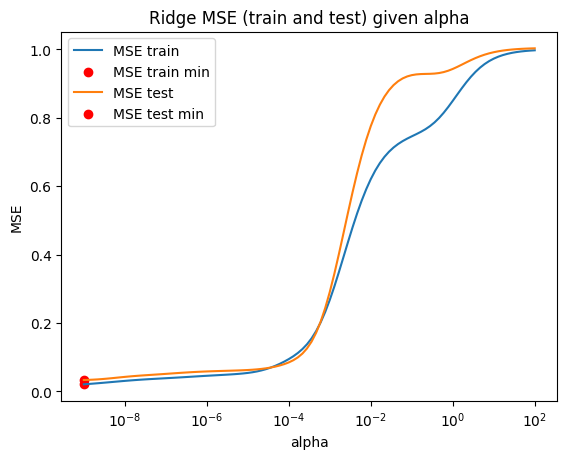

In [17]:
# function that calculates the MSE of a prediction, given an estimator
def MSE(X, Y, estimator):
    n = X.shape[0]
    return 1/n*(np.linalg.norm(X.to_numpy() @ estimator - Y.to_numpy())**2)


# 5.b - Plot how MSE of both the train and test sets change with alpha. Signal the minimum with a point.
ridge_alphas = np.logspace(-9, 2, num=100)

ridge_MSE_train = np.array([MSE(si_X_train, Y_train, theta_n_ridge(
    si_X_train, Y_train, alpha)) for alpha in ridge_alphas])
ridge_MSE_test = np.array([MSE(si_X_test, Y_test, theta_n_ridge(
    si_X_train, Y_train, alpha)) for alpha in ridge_alphas])

plt.figure()
plt.rcdefaults()

ax = plt.gca()
ax.set_xscale('log')

# getting indexes which minimize MSE
ridge_argmin_test = ridge_MSE_test.argmin()
ridge_argmin_train = ridge_MSE_train.argmin()

ax.plot(ridge_alphas, ridge_MSE_train)
ax.scatter(ridge_alphas[ridge_argmin_train],
           ridge_MSE_train[ridge_argmin_train], color='red')

ax.plot(ridge_alphas, ridge_MSE_test)
ax.scatter(ridge_alphas[ridge_argmin_test],
           ridge_MSE_test[ridge_argmin_test], color='red')


plt.xlabel('alpha')
plt.ylabel('MSE')
plt.title('Ridge MSE (train and test) given alpha')

ax.legend(['MSE train', 'MSE train min', 'MSE test', 'MSE test min'])

plt.show()

One more time, one can notice that the MSE of the train set is lower than the MSE of the test set, which is logical as we use the train set to calculate the estimator. It fits better the data of the train set.

To store the $R_2$ coefficients, we will choose alpha which minimizes the MSE of the test set. It is this **value which is useful in practice**.

In [18]:
# 5.c - For the best performing value of alpha (the one with smallest training error) store the R2 results.
ridge_argmin_test = ridge_MSE_test.argmin()

temp = pd.DataFrame({
    'OLS-type': ['Ridge estimator'],
    'R2-train': [R2_coeff(si_X_train, Y_train, theta_n_ridge(si_X_train, Y_train, ridge_alphas[ridge_argmin_test]))],
    'R2-test': [R2_coeff(si_X_test, Y_test, theta_n_ridge(si_X_train, Y_train, ridge_alphas[ridge_argmin_test]))],
    'Feature number': [X_train.shape[1]]
})

# printing MSE
ridge_mse = MSE(si_X_test, Y_test, theta_n_ridge(
    si_X_train, Y_train, ridge_alphas[ridge_argmin_test]))
print(f"MSE of the Ridge estimator for the test set : ", ridge_mse)


df_coef = pd.concat([df_coef, temp]).drop_duplicates(
    subset=['OLS-type'], keep='last').reset_index().drop(['index'], axis=1)
df_coef

MSE of the Ridge estimator for the test set :  0.03336158813516248


,OLS-type,R2-train,R2-test,Feature number
0,Regular OLS,0.995789,0.960055,100
1,Forward Variable Selection,0.969415,0.955180,23
2,Sequential Feature Selector,0.986747,0.938730,23
3,Ridge estimator,0.979292,0.966777,100


## Crossvalidation, Lasso and elastic net
### Question 6 - Testing Lasso estimator

One more time, we use scale invariant datasets, named `si_X_train` and `si_X_test` in this notebook.

In [19]:
def theta_n_lasso(X, Y, alpha, _max_iter, _tol):
    lasso_reg = Lasso(alpha, fit_intercept=False, max_iter=_max_iter, tol=_tol)
    lasso_reg.fit(X, Y)
    return np.array([lasso_reg.coef_]).T


#### Question 6.a - Why do we get warnings ?
The warnings happen as the algorithm does not converge and reached `max_iter`. To reach the convergence, one can either increase `max_iter` to have more iterations, or increase `tol` to have a more flexible stopping criteria.

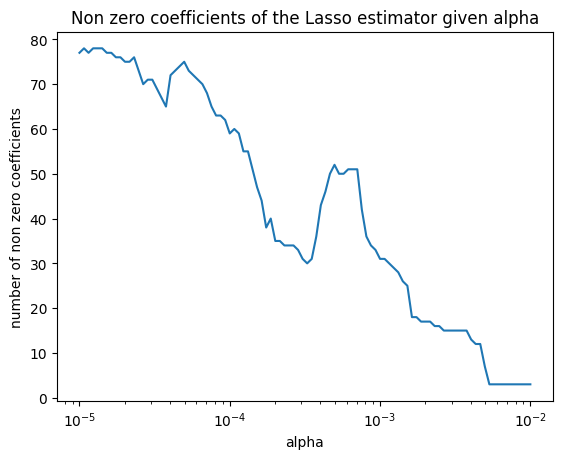

In [20]:
# 6.b - Plotting the number of coefficients that are different from 0 for each value of alpha
lasso_alphas = np.logspace(-5, -2, num=100)

# counting the number of non null coefficient for each value of alpha.
_max_iter = 10_000
_tol = 0.02
non_zero_coeff = np.array([np.count_nonzero(theta_n_lasso(
    si_X_train, Y_train, alpha, _max_iter, _tol)) for alpha in lasso_alphas])

plt.figure()
plt.rcdefaults()

ax = plt.gca()
ax.set_xscale('log')

plt.xlabel('alpha')
plt.ylabel('number of non zero coefficients')
plt.title('Non zero coefficients of the Lasso estimator given alpha')

ax.plot(lasso_alphas, non_zero_coeff)

plt.show()

As the Lasso estimator formula tells, all the coefficient tend to 0 as alpha goes to infinity. It is a consequence of the fact that the right term of the minimizing problem $\|Y-X \theta\|_2^2+ \alpha\|\boldsymbol{\theta}\|_1^2$ associated to the Ridge estimator, becomes preponderant. Minimizing this problem requires $\theta = 0$ starting from $\alpha$ great enough.

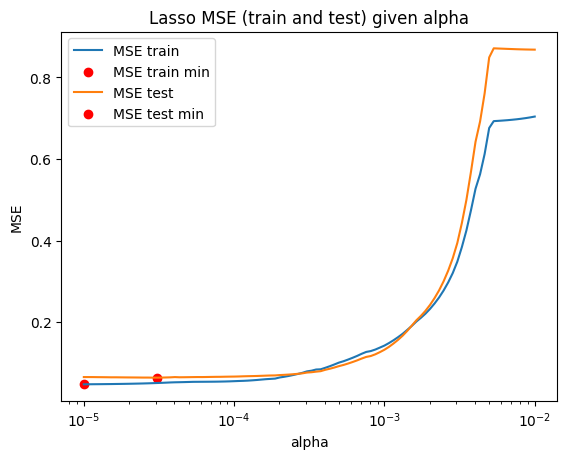

In [21]:
# 6.c - plotting how MSE of both the train and test sets change with alpha. Signal the minimum with a point.
lasso_MSE_train = np.array([MSE(si_X_train, Y_train, theta_n_lasso(
    si_X_train, Y_train, alpha, _max_iter, _tol)) for alpha in lasso_alphas])
lasso_MSE_test = np.array([MSE(si_X_test, Y_test, theta_n_lasso(
    si_X_train, Y_train, alpha, _max_iter, _tol)) for alpha in lasso_alphas])

plt.figure()
plt.rcdefaults()

ax = plt.gca()
ax.set_xscale('log')

# getting indexes which minimize MSE
lasso_argmin_test = lasso_MSE_test.argmin()
lasso_argmin_train = lasso_MSE_train.argmin()

ax.plot(lasso_alphas, lasso_MSE_train)
ax.scatter(lasso_alphas[lasso_argmin_train],
           lasso_MSE_train[lasso_argmin_train], color='red')

ax.plot(lasso_alphas, lasso_MSE_test)
ax.scatter(lasso_alphas[lasso_argmin_test],
           lasso_MSE_test[lasso_argmin_test], color='red')

plt.xlabel('alpha')
plt.ylabel('MSE')
plt.title('Lasso MSE (train and test) given alpha')

ax.legend(['MSE train', 'MSE train min', 'MSE test', 'MSE test min'])

plt.show()

In [22]:
# 6.d - Storing R_2 results for the best performing value of alpha on the test set.
lasso_argmin_test = lasso_MSE_test.argmin()

temp = pd.DataFrame({
    'OLS-type': ['Lasso estimator'],
    'R2-train': [R2_coeff(si_X_train, Y_train, theta_n_lasso(si_X_train, Y_train, lasso_alphas[lasso_argmin_test], _max_iter, _tol))],
    'R2-test': [R2_coeff(si_X_test, Y_test, theta_n_lasso(si_X_train, Y_train, lasso_alphas[lasso_argmin_test], _max_iter, _tol))],
    'Feature number': [X_train.shape[1]]
})

df_coef = pd.concat([df_coef, temp]).drop_duplicates(
    subset=['OLS-type'], keep='last').reset_index().drop(['index'], axis=1)
df_coef

,OLS-type,R2-train,R2-test,Feature number
0,Regular OLS,0.995789,0.960055,100
1,Forward Variable Selection,0.969415,0.955180,23
2,Sequential Feature Selector,0.986747,0.938730,23
3,Ridge estimator,0.979292,0.966777,100
4,Lasso estimator,0.949233,0.936322,100


One can notice that the $R_2$-test of the lasso estimator and the ridge estimator still have satisfying $R_2$ coefficients, even if the $R_2$-test coefficient of the lasso estimator is a bit lower. However, using the lasso estimator, despite a bias, reduces the risk of overfitting.

### Question 7 - Cross validation applied to Elastic Net

Implementing cross validation for Elastic Net estimator.

The `ElasticNet` function from `sklearn` requires 2 arguments defined as follows : 

$$\alpha_{cv} = \alpha_{lasso} + \alpha_{ridge}$$
$$l_1 = \frac{\alpha_{lasso}}{\alpha_{lasso}+\alpha_{ridge}}$$

In [23]:
# implementing cross validation for ElasticNet estimator
def cross_validation_en(X, Y, alphas_ridge, alphas_lasso, _max_iter_en, _tol_en, K=5):
    kf = KFold(n_splits=K, shuffle=True, random_state=0)
    # matrix of error. A row gives the errors given alpha for one specific split of the data
    errors = np.array([])

    # making couples of coefficients
    alphas = []
    for alpha_ridge in alphas_ridge:
        for alpha_lasso in alphas_lasso:
            alphas.append([alpha_ridge, alpha_lasso])

    # splitting the data using KFold
    for train_index, test_index in kf.split(X):
        X_train_temp = X.iloc[train_index, :]
        Y_train_temp = Y.iloc[train_index, :]
        X_test_temp = X.iloc[test_index, :]
        Y_test_temp = Y.iloc[test_index, :]

        temp_errors = []

        for alpha in alphas:
            alpha_ridge = alpha[0]
            alpha_lasso = alpha[1]

            # determining penalty coefficients of the elastic net estimator
            a = alpha_lasso
            b = alpha_ridge * X.shape[0]

            en_alpha = a + b
            l_one_ratio = a / (a + b)

            # fitting an elastic net estimator
            en = ElasticNet(alpha=en_alpha, l1_ratio=l_one_ratio,
                            fit_intercept=False, max_iter=_max_iter_en, tol=_tol_en)
            en.fit(X_train_temp, Y_train_temp)

            temp_errors.append(mean_squared_error(
                en.predict(X_test_temp), Y_test_temp))

        if errors.shape[0] == 0:
            errors = np.array([temp_errors])
        else:
            errors = np.concatenate((errors, np.array([temp_errors])))

    # computing the average error among all splits by value of alpha
    alphas_average_errors = np.array(
        [errors[:, i].mean() for i in range(len(alphas))])

    # getting the alpha minimizing the average mean square error of all permutations
    argmin = alphas_average_errors.argmin()

    # returninf the lasso and ridge penalty coefficients which minimize the average MSE
    return alphas[argmin]

Now, one gets the returned values of the cross validation and applies is to fit an Elastic Net estimator with these parameters.

In [24]:
# defining variables
cv_lasso_alphas = [0.00001, 0.1, 0.2, 0.5, 0.7, 0.9, 0.99]
cv_ridge_alphas = np.logspace(-10, 3, num=7)

_max_iter_en = 50_000
_tol_en = 0.1

# applying the calculation
alpha = cross_validation_en(
    si_X_train, Y_train, cv_ridge_alphas, cv_lasso_alphas, _max_iter_en, _tol_en, 5)
ridge_coefficient, lasso_coefficient = alpha[0], alpha[1]
print(f"Calculated ridge coefficient : {ridge_coefficient}")
print(f"Calculated lasso coefficient : {lasso_coefficient}")


en_alpha = X_train.shape[0] * ridge_coefficient + lasso_coefficient
l_one_ratio = lasso_coefficient / \
    (X_train.shape[0] * ridge_coefficient + lasso_coefficient)
en = ElasticNet(alpha=en_alpha, l1_ratio=l_one_ratio,
                fit_intercept=False, max_iter=_max_iter_en, tol=_tol_en)
en.fit(si_X_train, Y_train)

# printing MSE
lasso_mse = mean_squared_error(X_test @ theta_n_lasso(si_X_train, Y_train,
                               lasso_MSE_test[lasso_argmin_test], _max_iter, _tol), Y_test)
en_mse = mean_squared_error(en.predict(si_X_test), Y_test)
print(f"\nMSE of the Elastic Net for the test set : ", en_mse)
print(f"MSE of the Lasso for the test set : ", lasso_mse)

# storing R2 coefficient of the estimated model
temp = pd.DataFrame({
    'OLS-type': ['Elastic Net'],
    'R2-train': [en.score(si_X_train, Y_train)],
    'R2-test': [en.score(si_X_test, Y_test)],
    'Feature number': [X_train.shape[1]]
})

df_coef = pd.concat([df_coef, temp]).drop_duplicates(
    subset=['OLS-type'], keep='last').reset_index().drop(['index'], axis=1)
df_coef

Calculated ridge coefficient : 2.1544346900318822e-06
Calculated lasso coefficient : 1e-05

MSE of the Elastic Net for the test set :  0.14269671380293966
MSE of the Lasso for the test set :  1.004238810101066


,OLS-type,R2-train,R2-test,Feature number
0,Regular OLS,0.995789,0.960055,100
1,Forward Variable Selection,0.969415,0.955180,23
2,Sequential Feature Selector,0.986747,0.938730,23
3,Ridge estimator,0.979292,0.966777,100
4,Lasso estimator,0.949233,0.936322,100
5,Elastic Net,0.846937,0.857895,100


In comparison with Lasso, Elastic Net estimator has lower $R_2$ coefficients (about 9% lower), both for train and test sets. However, it divides by 7 the value of the Lasso MSE, which is a great asset of this model.

## Bootstrap
### Question 8 - 1D case

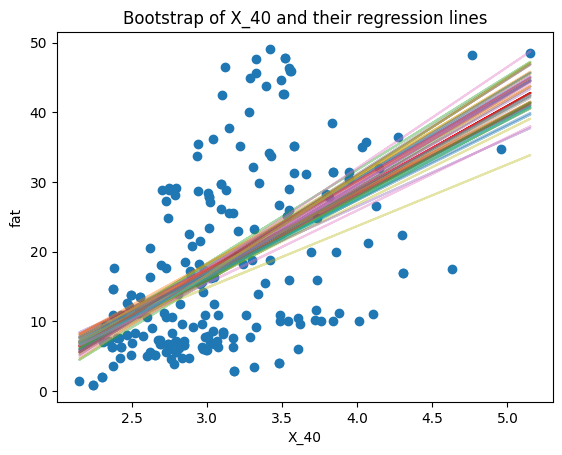

In [25]:
# linear regression with the feature 40
bootstrap_lg = LinearRegression(fit_intercept=True)
bootstrap_lg.fit(df[["V40"]], df[["fat"]])

y_predict = bootstrap_lg.coef_[0, 0] * df["V40"] + bootstrap_lg.intercept_

# plotting the dataset given the variable 40.
plt.figure()
plt.rcdefaults()

plt.title("Bootstrap of X_40 and their regression lines")
plt.ylabel("fat")
plt.xlabel("X_40")

ax2 = plt.gca()

ax2.scatter(df["V40"], df["fat"])
ax2.plot(df["V40"], y_predict, color='red')

# Generating 50 bootstrap samples
X_40 = df["V40"].to_numpy()
y = df["fat"].to_numpy()

for i in range(50):
    X_sample = np.array(
        [resample(df["V40"].to_numpy(), n_samples=len(df["V40"]), random_state=i)]).T
    y_sample = np.array(
        [resample(df["fat"].to_numpy(), n_samples=len(df["fat"]), random_state=i)]).T

    bootstrap_lg = LinearRegression(fit_intercept=True)
    bootstrap_lg.fit(X_sample, y_sample)

    # plotting the regression function of each bootstrap
    plt.plot(df["V40"], bootstrap_lg.coef_[0, 0] *
             df["V40"] + bootstrap_lg.intercept_, alpha=.4)


plt.show()

#### Confidence intervals

To plot the prediciton intervals for each sample, we need first to compute the lower and upper bounds. We start from the result given in the exercise 5 of the lecture notes :

$$\frac{Y - (\hat{\beta}_0 + \hat{\beta}_1 x)}{\hat{\sigma}\sqrt{1+\frac{1}{n} + \frac{(x-\bar{x}^n)^2}{\sum_{i=1}^n (x_i-\bar{x}^n)^2} }} \sim t(n-2)$$
<br><br><br>
Where $$\hat{\sigma}^2=\frac{1}{n-2}\sum_{i=1}^n(Y_i-(\hat{\beta}_0 + \hat{\beta}_1 x))^2$$

Denoting by $t_{1-\frac{\alpha}{2}}$ the quantile of order $1-\frac{\alpha}{2}$ of the Student's distribution with $n-2$ degrees of freedom, the prediction interval is :
<br><br><br><br>

$$Y \in \left[\hat{\beta}_0 + \hat{\beta}_1 x - t_{1-\frac{\alpha}{2}}\hat{\sigma}\sqrt{1+\frac{1}{n} + \frac{(x-\bar{x}^n)^2}{\sum_{i=1}^n (x_i-\bar{x}^n)^2}}\hspace{5pt} , \hspace{5pt} \hat{\beta}_0 + \hat{\beta}_1 x + t_{1-\frac{\alpha}{2}}\hat{\sigma}\sqrt{1+\frac{1}{n} + \frac{(x-\bar{x}^n)^2}{\sum_{i=1}^n (x_i-\bar{x}^n)^2}} \hspace{3pt}\right]$$

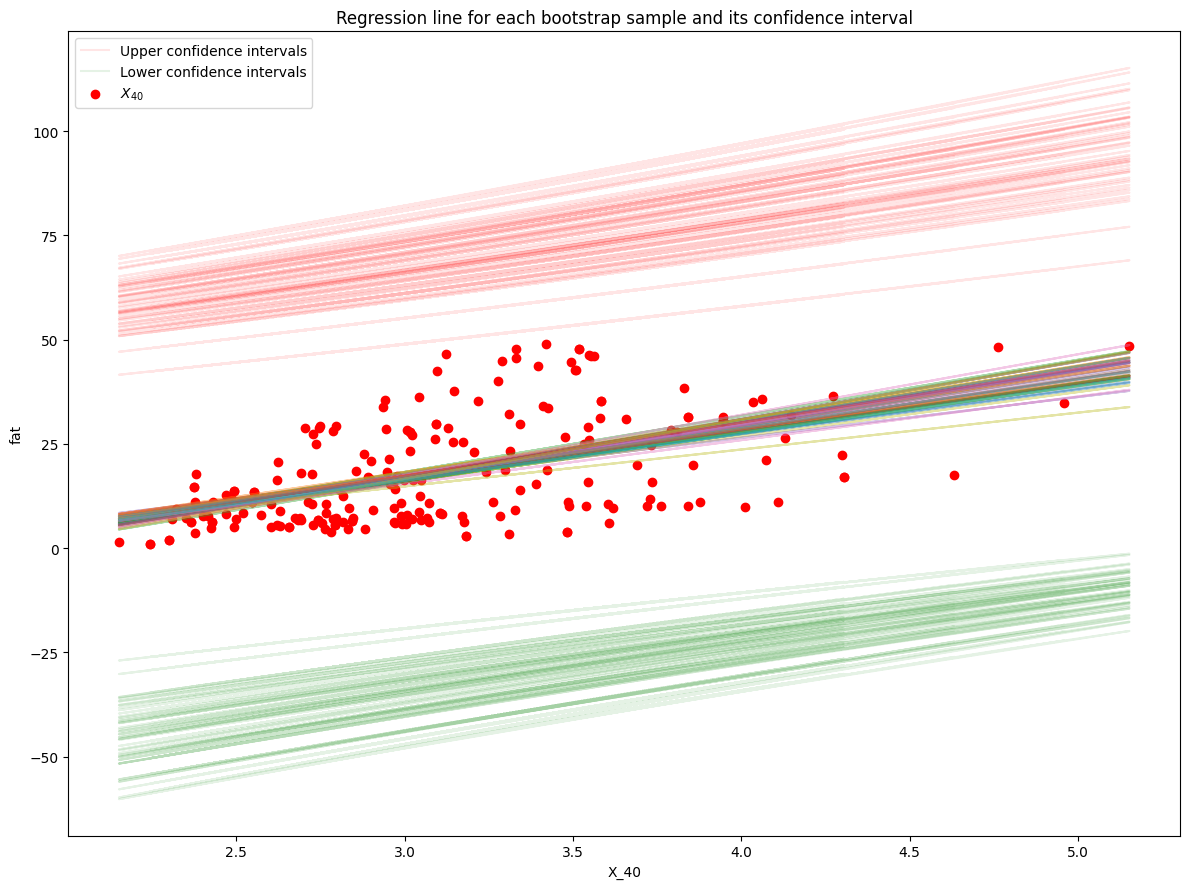

In [26]:
bootstrap_samples = 50  # Number of bootstrap samples
coefs = []  # List of the coefficients of the OLS
intercepts = []  # List of the intercept of the OLS
intervals = []

alpha = 0.05

reg_bootstrap = LinearRegression(fit_intercept=True)

plt.figure(figsize=(12, 9))
plt.rcdefaults()

plt.title('Regression line for each bootstrap sample and its confidence interval')
plt.xlabel('X_40')
plt.ylabel('fat')


for i in range(bootstrap_samples):
    X_sample, y_sample = resample(
        X_40, y, n_samples=len(X_40), random_state=i, replace=True)

    X_sample_mean = np.mean(X_sample)
    y_sample_mean = np.mean(y_sample)

    reg_bootstrap.fit(X_sample.reshape(-1, 1), y_sample)
    coef = reg_bootstrap.coef_
    intercept = reg_bootstrap.intercept_

    sigma = 1/(X_train.shape[0]-2)*((y_sample - coef * X_sample)**2).sum()
    temp = np.sqrt(sigma * (1 + X_train.shape[0]**-1 + (X_40 - X_sample_mean)**2 / (
        (X_sample - X_sample_mean)**2).sum())) * t.ppf(1-0.5*alpha, X_train.shape[0]-2)

    lower = intercept + coef * X_40 - temp
    upper = intercept + coef * X_40 + temp

    coefs.append(coef)
    intercepts.append(intercept)

    plt.plot(X_40.reshape(-1, 1),
             reg_bootstrap.coef_[0] * X_40 + reg_bootstrap.intercept_, alpha=.4)
    plt.plot(X_40.reshape(-1, 1), upper, alpha=.1, c='red',
             label=('Upper confidence intervals' if i == 0 else ''))
    plt.plot(X_40.reshape(-1, 1), lower, alpha=.1, c='green',
             label=('Lower confidence intervals' if i == 0 else ''))

alpha = 0.05  # Set a 5% confidence interval

plt.scatter(X_40, y, label=r'$X_{40}$', c='red')

plt.legend()
plt.tight_layout()
plt.show()

One may notice that all the points belong to the intersection of all the confidence intervals. This is a good indicator to check if they are well computed, as the data is supposed to belong to each confidence interval with a probability of $95$%.

## PCA
### Question 9 - Covariance matrix and SVD decomposition

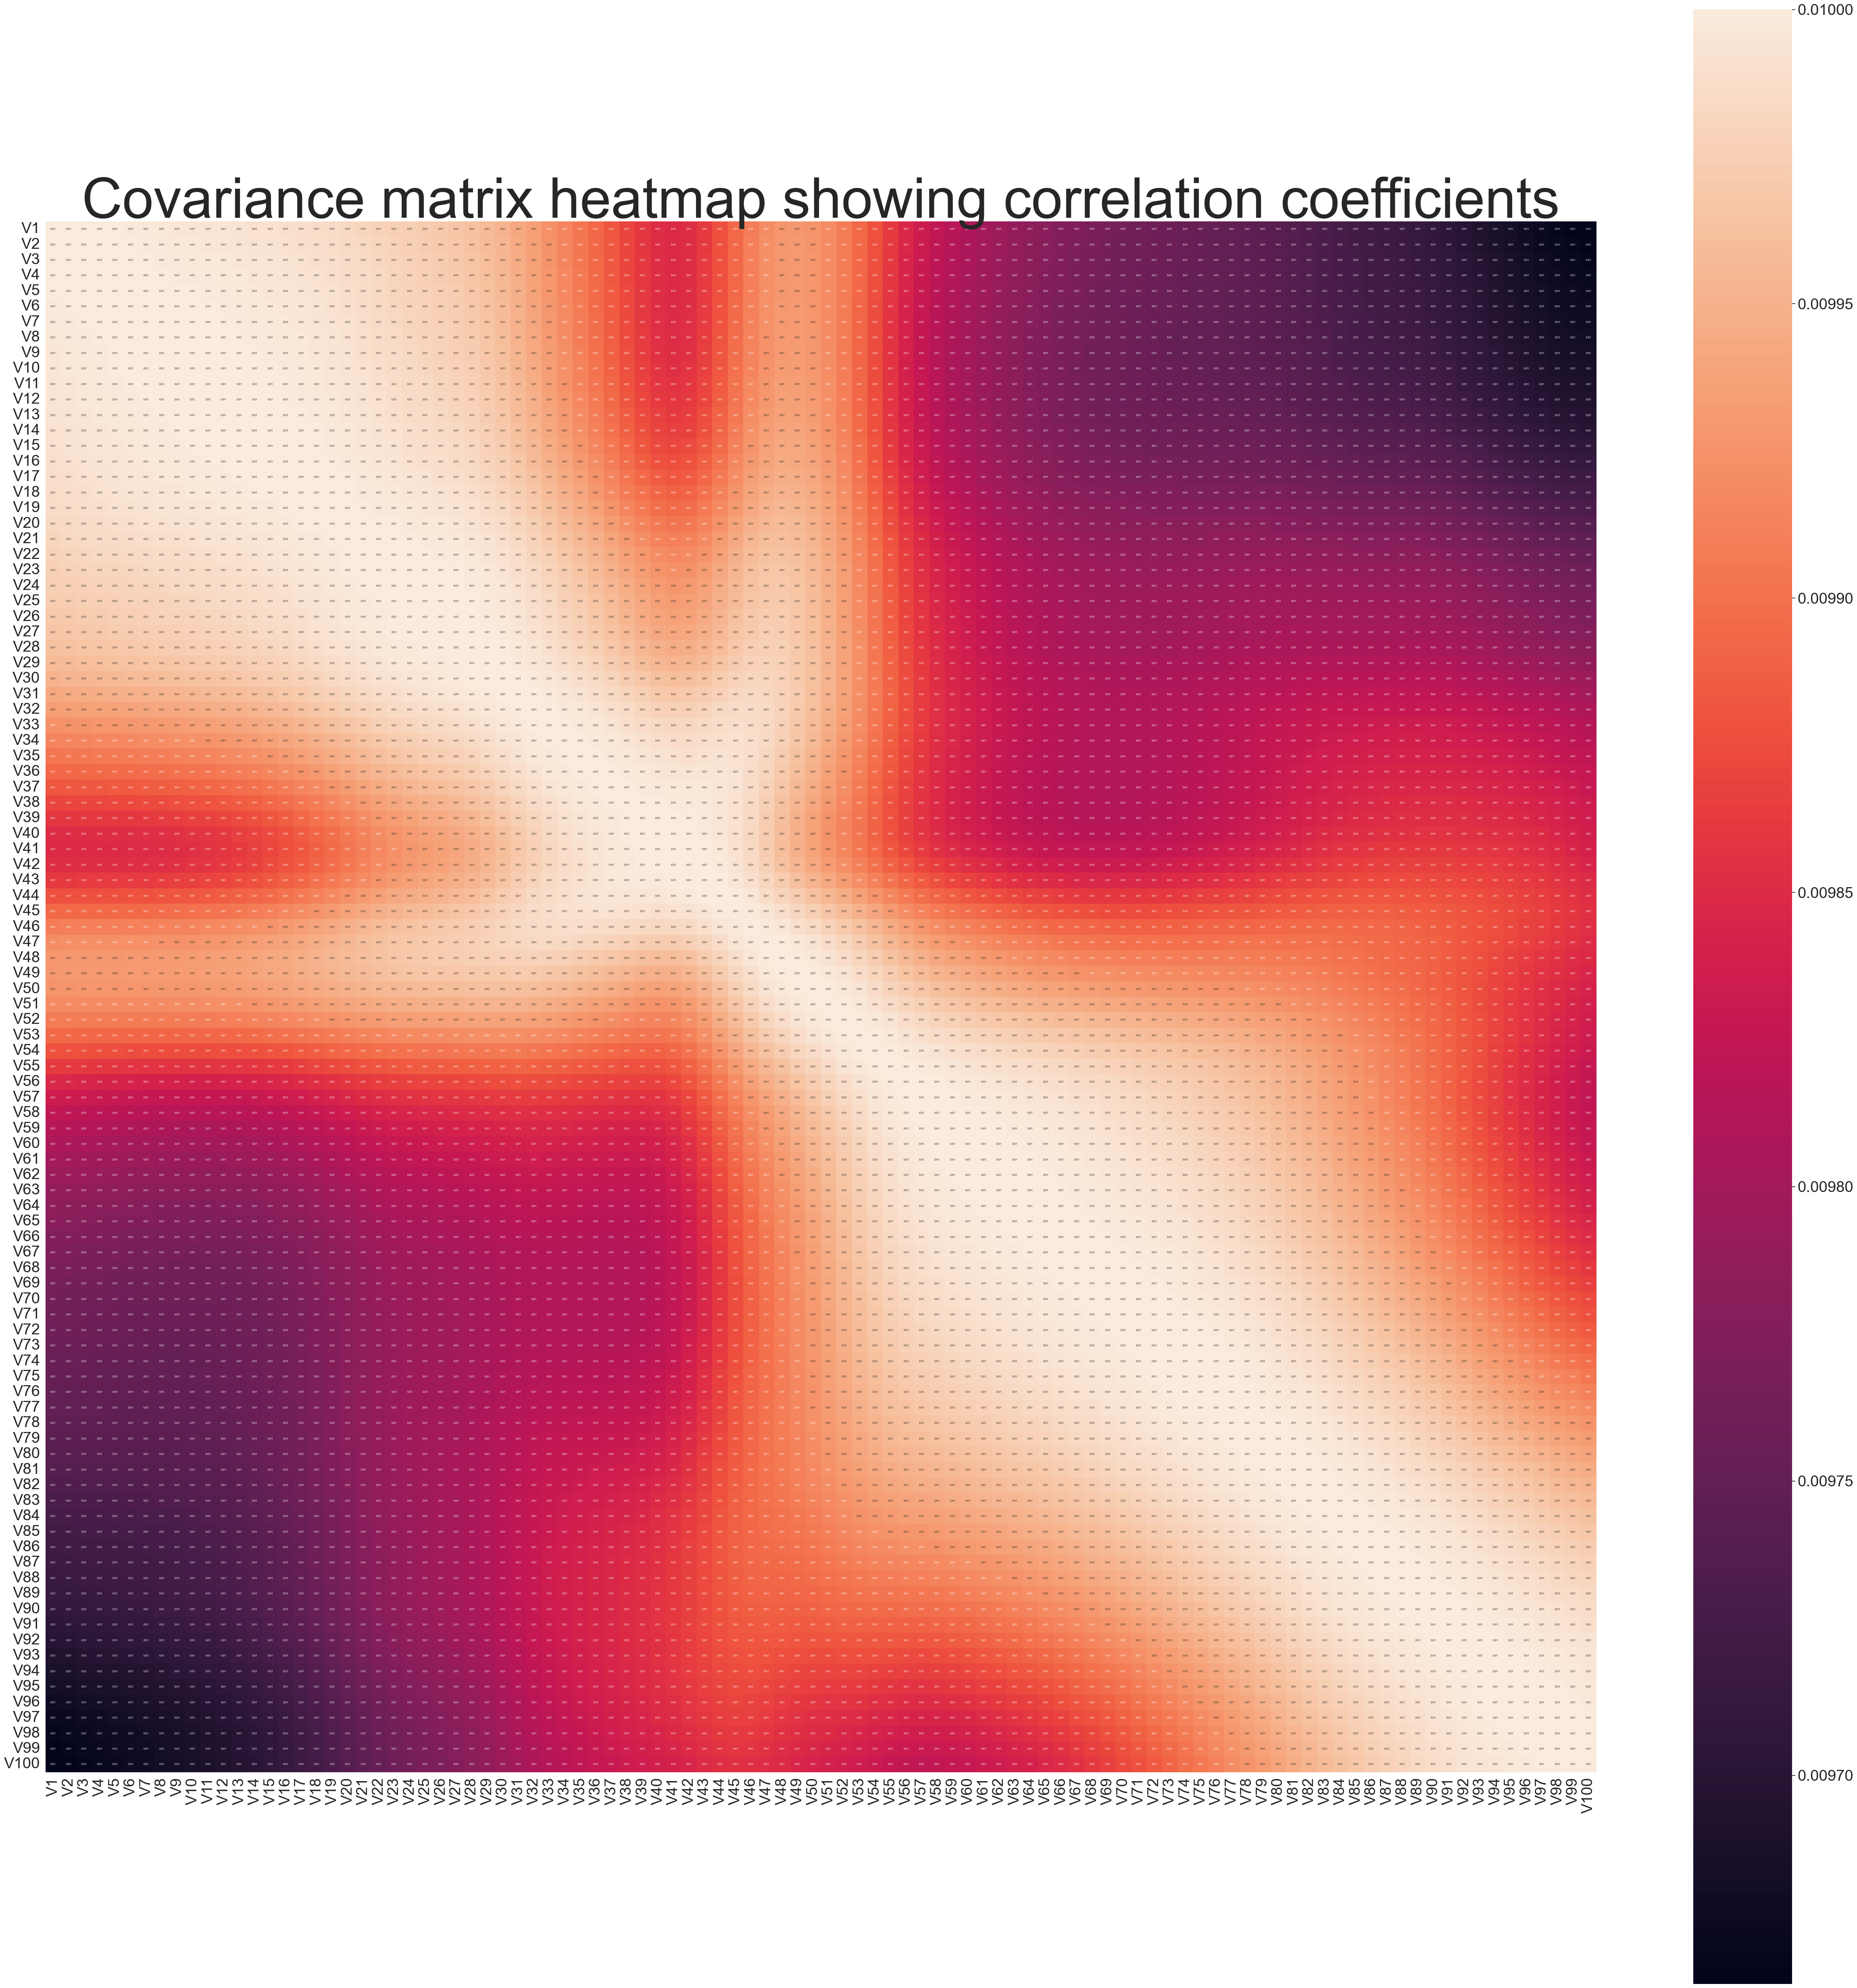

In [27]:
# taking scale invariant version of X_train for the PCA
cov_matrix_train = si_X_train.T @ si_X_train / si_X_train.shape[1]

# 9.a - plotting the heatmap of the covariance matrix for some features using the p-value of the forward variable selection

plt.figure(figsize=(50, 50))
plt.rcdefaults()

sns.set(font_scale=2.5)
hm = sns.heatmap(cov_matrix_train,
                 cbar=True,
                 annot=True,
                 square=True,
                 fmt='.2f',
                 xticklabels=X_train.columns,
                 yticklabels=X_train.columns,
                 annot_kws={'size': 5})
hm.axes.set_title(
    "Covariance matrix heatmap showing correlation coefficients", fontsize=100)
plt.tight_layout()

plt.show()

One may notice this is a symmetric matrix, which is a property of the covariance matrix. <br>
Now, we compute the SVD decomposition and perform the PCA of the dataset.

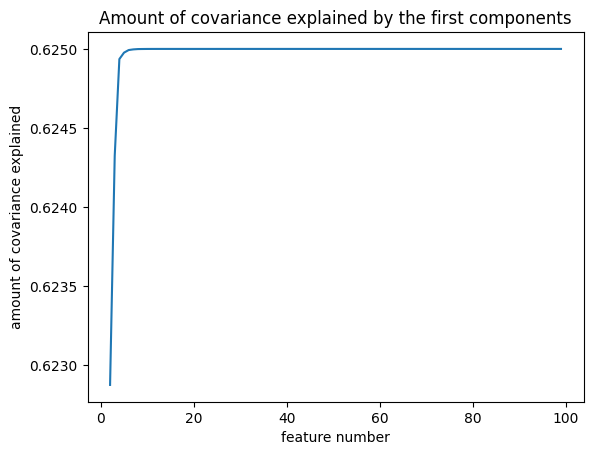

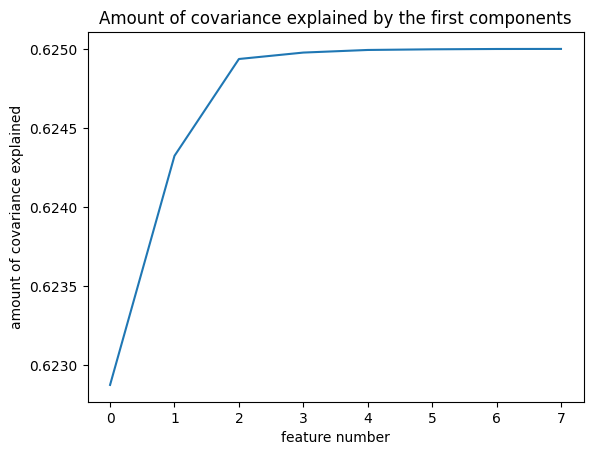

In [28]:
# SVD of the empirical covariance. X must be scale invariant.

def PCA(X):

    # Compute covariance matrix of features
    cov_matrix = X.T @ X / X.shape[1]

    # SVD
    U, s, V = np.linalg.svd(cov_matrix)

    X_PCA = X @ U

    return U, s, V, X_PCA


# computing the SVD od the train and test sets
U_train, s_train, V_train, X_train_PCA = PCA(si_X_train)
U_test, s_test, V_test, X_test_PCA = PCA(si_X_test)


# 9.b,c - displaying amount of explained variance of the coordinates
variances = [X_train_PCA[k].std()**2 for k in range(X_train_PCA.shape[1])]
explained_variance = [sum(variances[:k])
                      for k in range(2, X_train_PCA.shape[1])]

plt.figure()
plt.rcdefaults()

ax3 = plt.gca()

plt.xlabel('feature number')
plt.ylabel('amount of covariance explained')
plt.title('Amount of covariance explained by the first components')
ax3.plot([k for k in range(2, X_train_PCA.shape[1])], explained_variance)

plt.show()

plt.figure()

ax4 = plt.gca()

plt.xlabel('feature number')
plt.ylabel('amount of covariance explained')
plt.title('Amount of covariance explained by the first components')
ax4.plot([k for k in range(8)], explained_variance[:8])

plt.show()

One can see that most of the variance is explained by the two first principal components. That's why it is relevant to consider only PC1 and PC2.

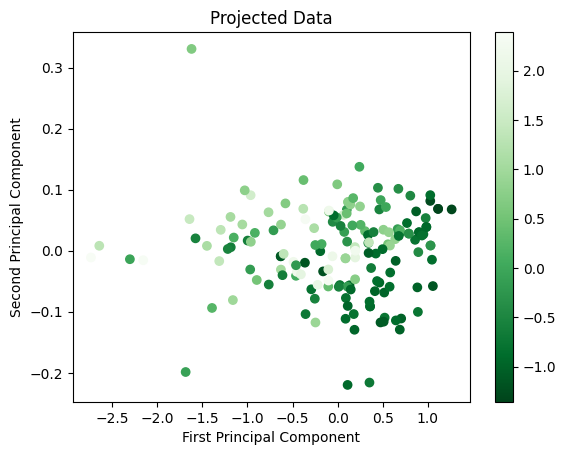

In [29]:
plt.figure()
plt.rcdefaults()

plt.scatter(X_train_PCA.loc[:, 0], X_train_PCA.loc[:,
            1], c=Y_train.iloc[:, 0], cmap='Greens_r')

plt.title("Projected Data")
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")
plt.colorbar()
plt.show()

plt.show()

First, reducing this problem to a two dimension one allows us to visualize it. Using the PCA allows doing it without losing too much information about the variance of the data.

Then, one may observe that the lowest values of ``Y_train`` are grouped together (on bottom right). Even if there is no clear cluster separation, values of ``Y_train`` are grouped together.

One observes one main cluster and some data points are far away from this cluster. It shows that there must be outliers in the data that must be removed or investigated.

Now, we will determine the number of principal features that minimizes the test score.

In [30]:
# 9.e - fitting a regular OLS using k principal components, k such that one gets the best test score
step = int((X_train_PCA.shape[1] - 1)/10)
reg = LinearRegression(fit_intercept=True)

# list of train and test scores given the number of components, and the associated feature number
train_scores = []
test_scores = []
feature_nb = []

# fitting a regular OLS given the k principal components
for k in range(2, X_train_PCA.shape[1], step):
    reg.fit(X_train_PCA.iloc[:, :k], Y_train)

    train_scores.append(reg.score(X_train_PCA.iloc[:, :k], Y_train))
    test_scores.append(reg.score(X_test_PCA.iloc[:, :k], Y_test))
    feature_nb.append(k)

# taking the number of components which maximizes the scores
argmax_test = np.argmax(test_scores)

# storing R2 coefficient of the estimated model
temp = pd.DataFrame({
    'OLS-type': [f'{feature_nb[argmax_test]}-PCA OLS'],
    'R2-train': [train_scores[argmax_test]],
    'R2-test': [test_scores[argmax_test]],
    'Feature number': [feature_nb[argmax_test]]
})

print(f"Best projected OLS for k = {feature_nb[argmax_test]} features.")

# printing MSE
reg.fit(X_train_PCA.iloc[:, :feature_nb[argmax_test]], Y_train)
pca_mse = mean_squared_error(reg.predict(
    X_test_PCA.iloc[:, :feature_nb[argmax_test]]), Y_test)
print(f"\nMSE of the PCA OLS for the test set : ", pca_mse)


df_coef = pd.concat([df_coef, temp]).drop_duplicates(
    subset=['OLS-type'], keep='last').reset_index().drop(['index'], axis=1)
df_coef

Best projected OLS for k = 11 features.

MSE of the PCA OLS for the test set :  0.10899100517337891


,OLS-type,R2-train,R2-test,Feature number
0,Regular OLS,0.995789,0.960055,100
1,Forward Variable Selection,0.969415,0.955180,23
2,Sequential Feature Selector,0.986747,0.938730,23
3,Ridge estimator,0.979292,0.966777,100
4,Lasso estimator,0.949233,0.936322,100
5,Elastic Net,0.846937,0.857895,100
6,11-PCA OLS,0.960576,0.891461,11


The $R_2$-train coefficient of the OLS using PCA is satisfying, but one may notice a more important decrease regarding the $R_2$-test coefficient, showing that the PCA OLS generalizes less well and explains less of the observed variance.

## Question 10

Let's compare the results obtained for each model over four axes : score, feature number, MSE and overfitting. First, we recall the score dataframe and we add the test MSE for each regression model.

In [31]:
df_coef['MSE'] = np.array(
    [ols_mse, ols_fvs_mse, ols_sfs_mse, ridge_mse, lasso_mse, en_mse, pca_mse]).round(3)
df_coef

,OLS-type,R2-train,R2-test,Feature number,MSE
0,Regular OLS,0.995789,0.960055,100,0.040
1,Forward Variable Selection,0.969415,0.955180,23,0.045
2,Sequential Feature Selector,0.986747,0.938730,23,0.062
3,Ridge estimator,0.979292,0.966777,100,0.033
4,Lasso estimator,0.949233,0.936322,100,1.004
5,Elastic Net,0.846937,0.857895,100,0.143
6,11-PCA OLS,0.960576,0.891461,11,0.109


### Score comparison
For almost all regression models, the $R_2$ scores are above $0.9$. Most of the models explain the main part of the observed variance and generalize well to the test set.

The exceptions are the Elastic Net and 11-PCA OLS. However, those two estimators have other advantages, mentioned below.


### Feature number
We studied methods to diminish the number of features required to perform linear regression.

- Forward Variable Selection and Sequential Variable Selection allow to divide by 4 the number of features and to keep high values of scores (decrease of about $1$% in comparison with the regular OLS). However, they require to perform several OLS over features to obtain this result. This is not the case of the PCA-OLS. 

- PCA allows do decrease the number of feature **before** performing any regression (the main difference with the other Variable Selection methods), avoiding computations over all the covariates, which makes it significantly more efficient. As said previously, the $R_2$-test score is a bit lower than for other regressions (about 7% lower than for Variable Selection methods). The generalization is less good, but it decreases by ten the number of required features.

### MSE
First let's take a look at the evolution of the MSE when reducing the number of covariates :
- Regular OLS and Variable Selection methods have close MSEs and remain strictly below $0.1$. Selecting the variables this way does not affect significantly the MSE.
- However, the PCA OLS has a MSE strictly greater than $0.1$. The efficiency of the computations has the drawback to lead to a significant increase of the MSE (about 60% more than the Sequential Feature Selector method).

Now, we compare regular OLS MSE to Ridge, Lasso and Elastic Net MSEs.
- The penalty parameter that minimizes the MSE  for the ridge estimator allows to decrease the MSE by 17% in comparison with the regular OLS, which is interesting.
- As for the Lasso estimator, the minimum value of the MSE is MSE(Lasso) $\approx 1.00$, which is about 25 times more than for the OLS estimator. This is significantly higher.
- Finally, the value of the MSE of the Elastic Net after cross validation is MSE(Elastic Net) $\approx 0.14$, which is about 3.5 times more than for the OLS estimator. It is still higher but far below the Lasso one.

The Elastic Net seems to be a good compromise between the Lasso estimator and the Ridge estimator, regarding MSE. <br>
Moreover, it has other advantages concerning overfitting in comparison with the OLS. However, one may note that its $R_2$-coefficients are lower than the Lasso and Ridge ones (about 9%).


### Overfitting
- The OLS method can give good results when the number of explanatory variables is low and the relationships between the variables are linear. However, it may suffer from **overfitting** if the number of covariates is high.

- Penalized regression methods such as Lasso and Ridge are designed to avoid overfitting and can often produce better R2 scores than the OLS method in the presence of many explanatory variables or correlations between variables. One may note that $R_2$-scores are not better for our dataset. The heatmap of the covariance matrix can help determine how correlated are the features. In this case, it looks like half of them have a strong correlation, while the rest of it is less correlated.
- The Elastic Net method combines the advantages of Lasso and Ridge : it reduces the risk of overfitting and is a good compromise between the Lasso MSE and the Ridge MSE. Nevertheless, it leads to lower $R_2$-scores.